In [1]:
import os
os.chdir("../..")

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent
from shell.fleet.data.send_utilize import *
from shell.fleet.data.recv import *

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
save_root_dir = "vanilla_remove_datasets_hack_results"
dataset = "mnist"
algo = "modular"
num_train = 64
seed = 0
use_contrastive = True

In [4]:
job_name = f"{dataset}_{algo}_numtrain_{num_train}"
if use_contrastive:
    job_name += "_contrastive"
experiment = os.path.join(save_root_dir, job_name, dataset,algo, f"seed_{seed}")

In [5]:
config_path = os.path.join(experiment, "hydra_out", ".hydra", "config.yaml")
# read the config file
cfg = omegaconf.OmegaConf.load(config_path)
cfg

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 1}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'vanilla_remove_datasets_hack_results', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}

In [6]:
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg = setup_experiment(cfg)
len(datasets)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 1}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'vanilla_remove_datasets_hack_results', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


8

In [7]:
task_id = 3
num_added_components = None
receiver_id = 0
sender_id = 2

In [8]:
cfg.sharing_strategy.name = "recv_data"
cfg.sharing_strategy.num_coms_per_round = 2
cfg.sharing_strategy.num_queries = 10
cfg.sharing_strategy.num_data_neighbors = 5
cfg.sharing_strategy.scorer = "cross_entropy"
cfg.sharing_strategy.query_score_threshold = 0.6931471805599453

In [9]:
receiver = RecvDataAgent(receiver_id, seed, datasets[receiver_id],
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                cfg.sharing_strategy)

sender = RecvDataAgent(sender_id, seed, datasets[sender_id],
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                cfg.sharing_strategy)

INFO:root:Agent: node_id: 0, seed: 0


INFO:root:Agent: node_id: 2, seed: 2000


In [10]:
receiver.net = load_net(cfg, NetCls, net_cfg, agent_id=receiver_id, task_id=task_id, num_added_components=num_added_components)
receiver.net

save_dir vanilla_remove_datasets_hack_results/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_0/task_3


MLPSoftLLDynamic(
  (structure): ParameterList(
      (0): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (2): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (3): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (4): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (5): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (6): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (7): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (8): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
      (9): Parameter containing: [torch.float32 of size 4x4 (GPU 0)]
  )
  (softmax): Softmax(dim=0)
  (components): ModuleList(
    (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (random_linear_projection): Linear(in_features=784, out_features=64, b

In [11]:
sender.net = load_net(cfg, NetCls, net_cfg, agent_id=sender_id, task_id=task_id, num_added_components=num_added_components)

save_dir vanilla_remove_datasets_hack_results/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_2/task_3


In [12]:
testloaders = {task: torch.utils.data.DataLoader(testset,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         num_workers=0,
                                                         pin_memory=True,
                                                         ) for task, testset in enumerate(datasets[receiver_id].testset[:(task_id+1)])}
eval_net(receiver.net, testloaders)

{0: 0.9668803418803419,
 1: 0.9844377510040161,
 2: 0.9788659793814433,
 3: 0.9799196787148594,
 'avg': 0.9775259377451653}

In [13]:
X_queries, y_queries, y_pred_queries, score_queries = receiver.compute_query(task_id=3, mode="all", debug_return=True)

In [14]:
X_queries.keys()

dict_keys([0, 1, 2, 3])

In [23]:
receiver.dataset.class_sequence

array([5, 0, 4, 3, 4, 6, 4, 3, 8, 0, 1, 0, 5, 9, 6, 4, 9, 0, 3, 0])

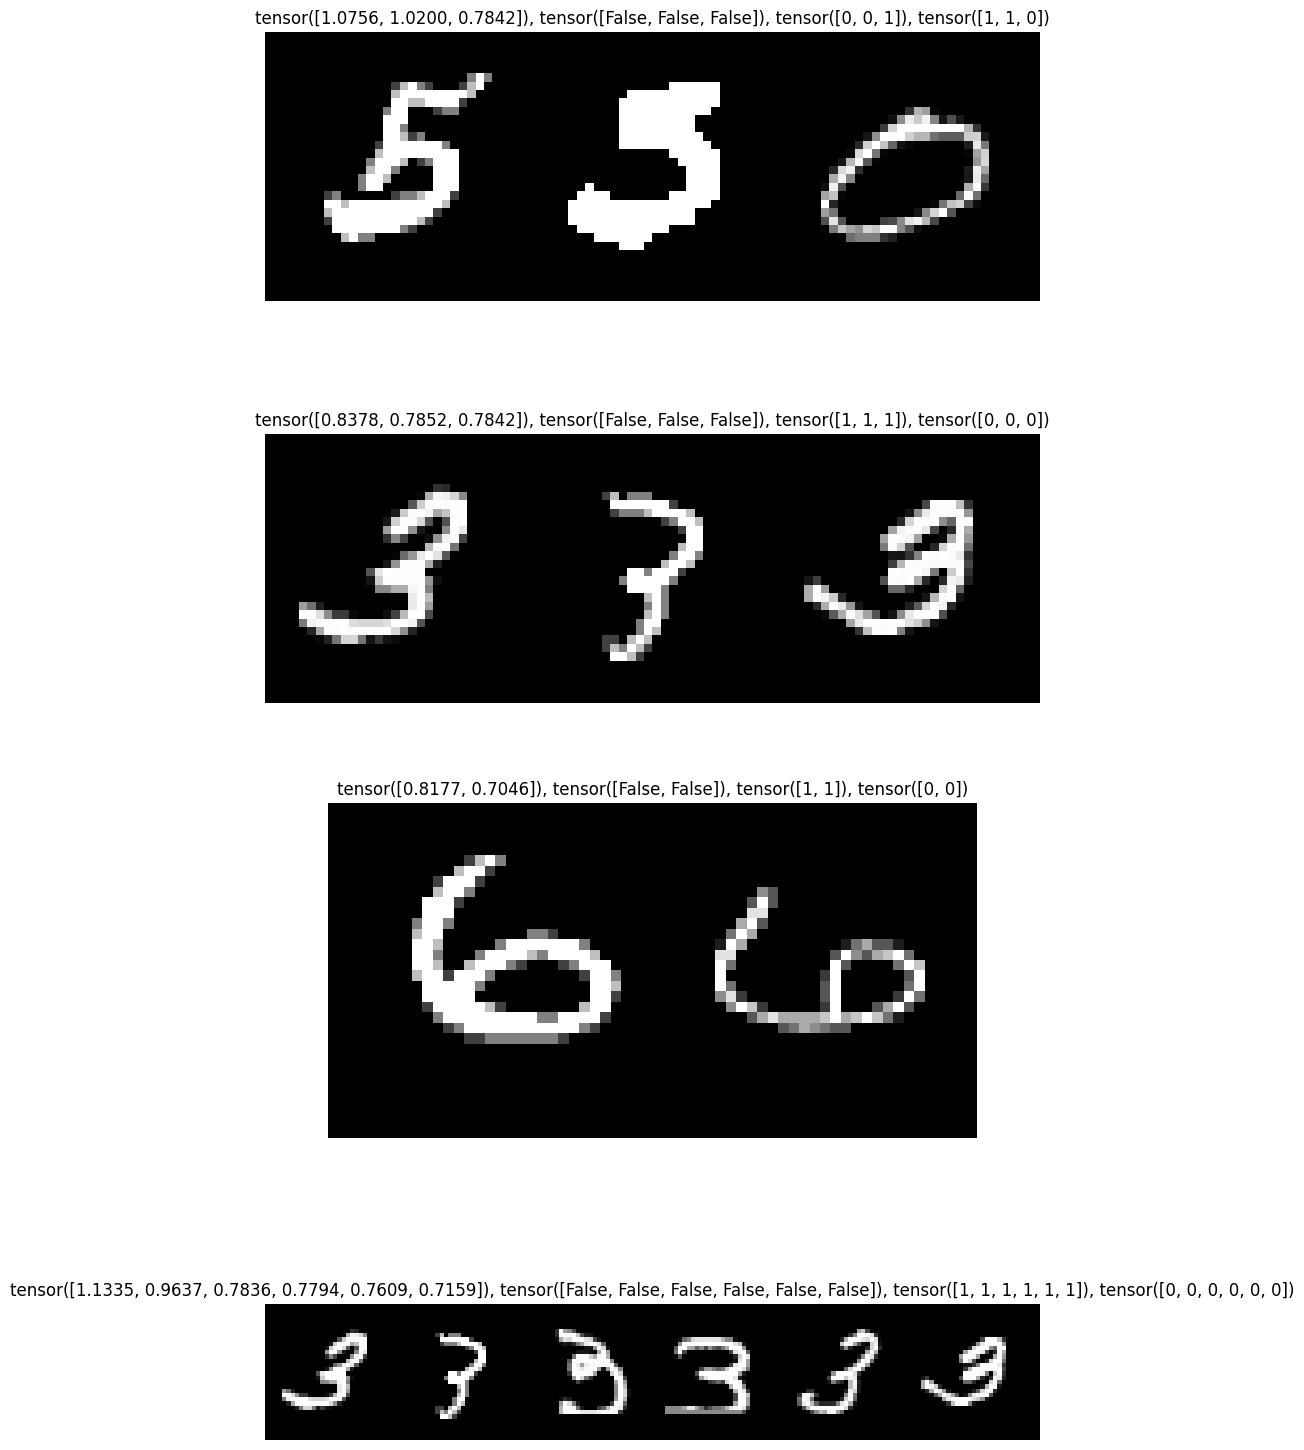

In [15]:
# visualize the queries using plt.imshow and make_grid
fig, axs = plt.subplots(len(X_queries), 1, figsize=(10, 20))

# correct is when y_queries == y_pred_queries
for t in range(len(X_queries)):
    X = X_queries[t]
    y_q = y_queries[t]
    y_p = y_pred_queries[t]
    correct = y_q == y_p
    from torchvision.utils import make_grid
    X = make_grid(X)
    axs[t].imshow(X.permute(1, 2, 0))
    axs[t].set_title(f"{score_queries[t]}, {correct}, {y_q}, {y_p}")
    axs[t].axis("off")


torch.Size([1, 28, 28])


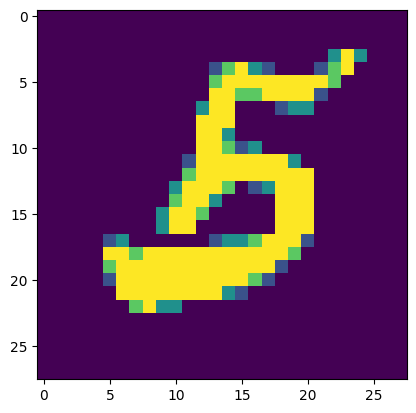

In [30]:
q = X_queries[0][0]
print(q.shape)
plt.imshow(q.permute(1, 2, 0));

In [33]:
q_val_sets, _  = receiver.get_valset(tasks=[0])
d = q_val_sets[0]
d.shape

torch.Size([100, 1, 28, 28])

In [50]:
# reshape q, and d to (N, dim)
q = q.reshape(-1, 28*28)
d = d.reshape(-1, 28*28)
sim = pairwise_cosine_similarity(q, d)
k = 5

top_k = torch.topk(sim, k, dim=1).indices
top_k_sim = d[top_k.flatten()]
top_k_sim.shape

torch.Size([5, 784])

In [51]:
sim.shape

torch.Size([1, 100])

In [53]:
sim.flatten()

tensor([0.4253, 0.3521, 0.2668, 0.4116, 0.3808, 0.6892, 0.3830, 0.5585, 0.7333,
        0.5711, 0.4155, 0.2630, 0.2861, 0.5686, 0.3061, 0.5387, 0.2548, 0.3944,
        0.3810, 0.3516, 0.5393, 0.4407, 0.4063, 0.2980, 1.0000, 0.3778, 0.5907,
        0.4224, 0.4074, 0.2754, 0.3756, 0.3864, 0.3561, 0.2815, 0.4605, 0.5190,
        0.5425, 0.3686, 0.5575, 0.6292, 0.3614, 0.2533, 0.2784, 0.5007, 0.4404,
        0.4477, 0.5574, 0.3710, 0.3313, 0.5128, 0.5000, 0.5045, 0.3248, 0.4499,
        0.5974, 0.2247, 0.4467, 0.4597, 0.5551, 0.4916, 0.4415, 0.4023, 0.5404,
        0.3888, 0.3971, 0.5078, 0.6850, 0.4598, 0.3300, 0.5749, 0.5183, 0.4487,
        0.4448, 0.4368, 0.3749, 0.3855, 0.3822, 0.2681, 0.5749, 0.2732, 0.4109,
        0.5224, 0.4565, 0.3843, 0.3530, 0.5034, 0.3320, 0.5012, 0.1904, 0.5454,
        0.3516, 0.3244, 0.5156, 0.6256, 0.4340, 0.4164, 0.6319, 0.5986, 0.5777,
        0.3678])

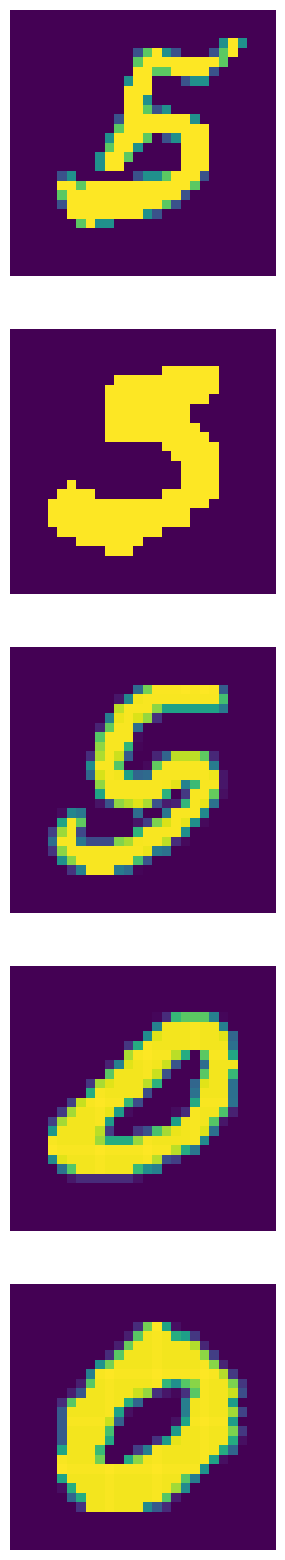

In [52]:
# plot top_k_sim
fig, axs = plt.subplots(k, 1, figsize=(10, 20))
for i in range(k):
    simi = top_k_sim[i]
    simi = simi.reshape(28, 28)
    axs[i].imshow(simi)
    axs[i].axis("off")

In [56]:
for t in range(task_id+1):
    trainloader = torch.utils.data.DataLoader(sender.dataset.trainset[t],
                                                            batch_size=128,
                                                            shuffle=True,
                                                            num_workers=0,
                                                            pin_memory=True,
                                                            )
    sender.agent.update_multitask_cost(trainloader, t)

sender.agent.replay_buffers

{0: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83f6d86f50>,
 1: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83e3916050>,
 2: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f8543588df0>,
 3: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83f6eb7340>}

In [57]:
for t in range(task_id+1):
    trainloader = torch.utils.data.DataLoader(receiver.dataset.trainset[t],
                                                            batch_size=128,
                                                            shuffle=True,
                                                            num_workers=0,
                                                            pin_memory=True,
                                                            )
    receiver.agent.update_multitask_cost(trainloader, t)

receiver.agent.replay_buffers

{0: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83f6eb7190>,
 1: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83e37dffa0>,
 2: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83fa35e800>,
 3: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7f83f6d87e50>}

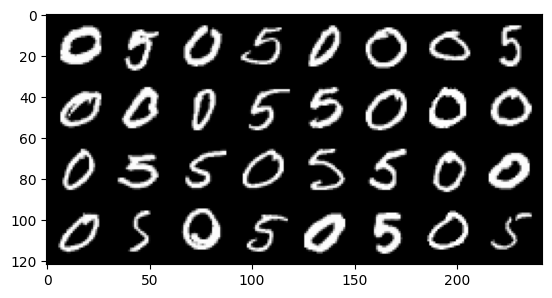

In [62]:
im = make_grid(receiver.agent.replay_buffers[0].tensors[0])
plt.imshow(im.permute(1, 2, 0));

In [74]:
# reshape q, and d to (N, dim)
d = receiver.agent.replay_buffers[0].tensors[0]
q = q.reshape(-1, 28*28)
d = d.reshape(-1, 28*28)
sim = pairwise_cosine_similarity(q, d).flatten()
sim.shape

torch.Size([32])

In [75]:
sim

tensor([0.5328, 0.4695, 0.5228, 0.4899, 0.7006, 0.2590, 0.3264, 0.5027, 0.4683,
        0.6674, 0.6038, 0.4242, 0.5572, 0.2712, 0.4448, 0.3742, 0.5829, 0.5182,
        0.5045, 0.3820, 0.3610, 0.5620, 0.3239, 0.5514, 0.4547, 0.4323, 0.4961,
        0.4529, 0.5677, 0.5454, 0.4432, 0.4997])

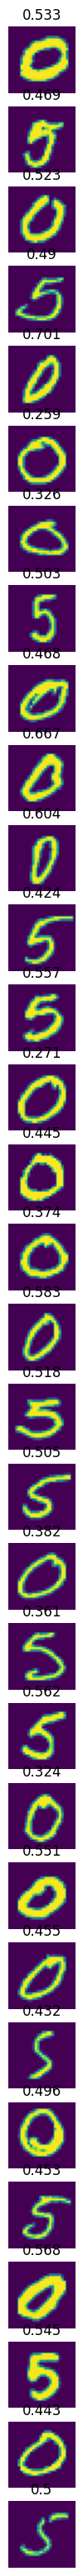

In [82]:
# plot each d[i] along with the similarity value
fig, axs = plt.subplots(len(d), 1, figsize=(10, 40))
for i in range(len(d)):
    simi = d[i]
    simi = simi.reshape(28, 28)
    axs[i].imshow(simi)
    axs[i].set_title(f"{sim[i]:.3}")
    axs[i].axis("off")

In [85]:
# received_data = sender.nearest_neighbors(X_queries[0], neighbors=10)
received_data = receiver.nearest_neighbors(X_queries[0], neighbors=10)
received_data.shape

torch.Size([3, 64])
torch.Size([32, 64])
sim torch.Size([3, 32])
torch.Size([3, 64])
torch.Size([32, 64])
sim torch.Size([3, 32])
torch.Size([3, 64])
torch.Size([32, 64])
sim torch.Size([3, 32])
torch.Size([3, 64])
torch.Size([32, 64])
sim torch.Size([3, 32])
sims: torch.Size([3, 128])
X_reps: torch.Size([128, 1, 28, 28])


torch.Size([3, 10, 1, 28, 28])

In [87]:
received_data[i].shape

torch.Size([10, 1, 28, 28])

In [ ]:
## NOTE: the image search seems to completely break down...
# TODO: look at the embedding space

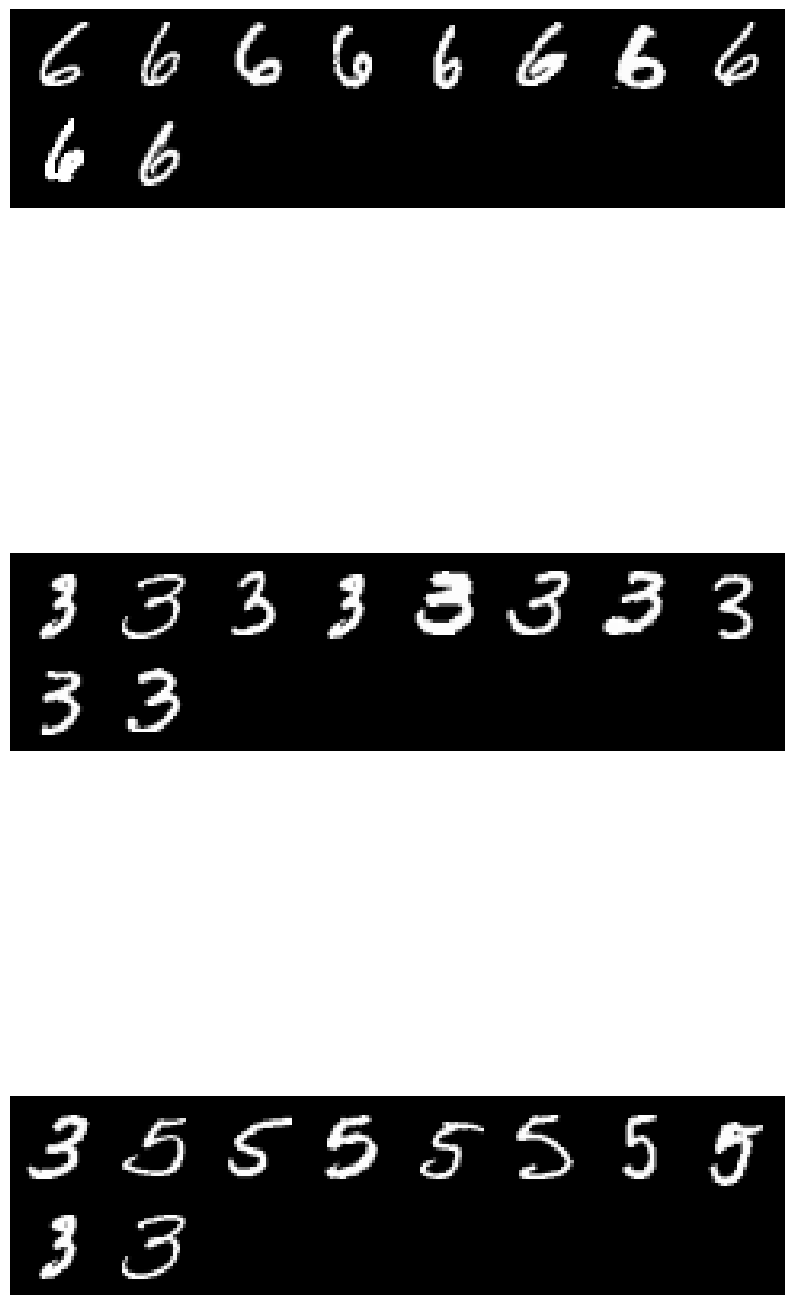

In [91]:
# plot received_data
fig, axs = plt.subplots(len(received_data), 1, figsize=(10, 20))
for i in range(len(received_data)):
    simi = received_data[i].cpu()
    # simi = simi.reshape(28, 28)
    simi = make_grid(simi)
    axs[i].imshow(simi.permute(1, 2, 0))
    axs[i].axis("off")

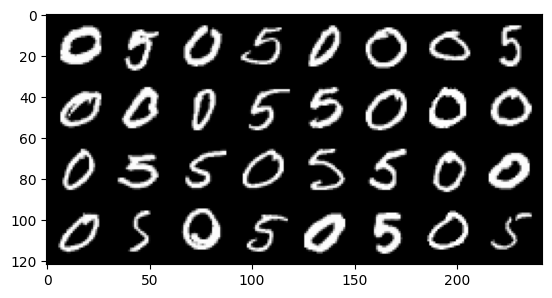

In [84]:
im = make_grid(receiver.agent.replay_buffers[0].tensors[0])
plt.imshow(im.permute(1, 2, 0))

In [20]:
# d = receiver.net.encode(receiver.agent.replay_buffers[0].tensors[0].to("cuda"), task_id=0)
# q = receiver.net.encode(X_queries[0][0].to("cuda"), task_id=0)
# print(d.shape, q.shape)
d = receiver.agent.replay_buffers[0].tensors[0].reshape(32, -1)
q = X_queries[0][0].reshape(1, -1)
print(d.shape, q.shape)
print(pairwise_cosine_similarity(q, d))

torch.Size([32, 784]) torch.Size([1, 784])
tensor([[0.3154, 0.4803, 0.2487, 0.4970, 0.6714, 0.4406, 0.6986, 0.6044, 0.6200,
         0.3881, 0.6449, 0.5618, 0.4846, 0.5069, 0.5085, 0.5572, 0.5937, 0.3820,
         0.5400, 0.3991, 0.5425, 0.4547, 0.4538, 0.4529, 0.2106, 0.6031, 0.3554,
         0.5183, 0.5070, 0.4598, 0.3904, 0.5812]])


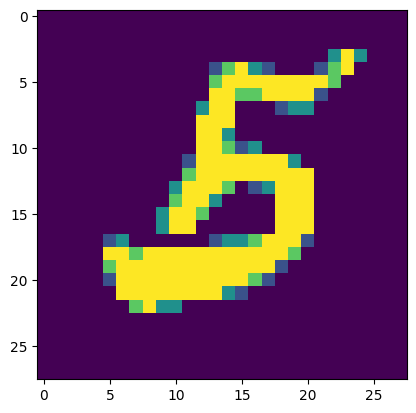

In [21]:
plt.imshow(X_queries[0][0].permute(1, 2, 0))

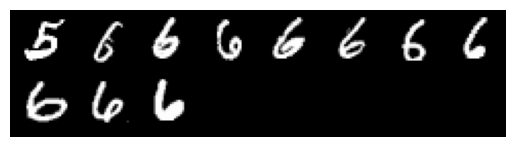

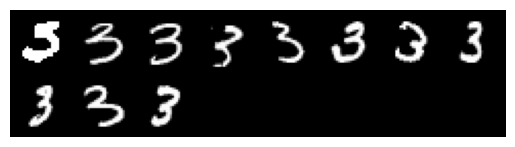

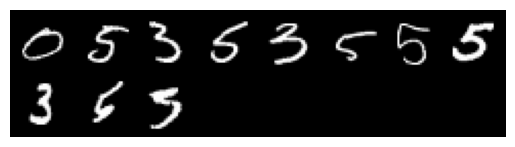

In [22]:
# visualize received data
for i in range(len(received_data)):
    X = received_data[i].cpu()
    # append the corresponding query
    query = X_queries[0][i].unsqueeze(0) # add one more dimension to the query
    X = torch.cat([query, X], dim=0)
    X = make_grid(X)
    plt.imshow(X.permute(1, 2, 0))
    plt.axis("off")
    plt.show()